In [3]:
import os
from typing import List
import random
import numpy as np
import pandas as pd
import seaborn as sns
from hashlib import md5
import matplotlib.pyplot  as plt


GRID_W=5
GRID_H=3
NUM_GRIDS=200

In [41]:
def write_grids(subsets:List[List],path:str):

    #Ensure directory exists
    if not os.path.isdir(path):
        os.mkdir(path)

    grids = [None]*len(subsets)

    #Format every subset in a grid format and save as CSV
    for i,subset in enumerate(subsets):
        csv_file = "".join([element + (';' if (j+1)%GRID_W else '\n')
                            for j,element in enumerate(subset)])[:-1]
        #                               Last character is \n   ^^^^^
        
        with open(os.path.join(path,f"{i}.csv"),"w") as f:
            f.write(csv_file)
        
        grid = csv_file.replace('\n',';').split(';')
        grids[i] = [grid[i:i + GRID_W] for i in range(0, len(grid), GRID_W)]

    return grids

def load_grids(path:str,n_grids:int) -> List[List]:

    grids = [None]*n_grids
    
    for i in range(n_grids):
        with open(os.path.join(path,f"{i}.csv"),"r") as f:
            csv_file = f.read()

        grid = csv_file.replace('\n',';').split(';')
        grids[i] = [grid[i:i + GRID_W] for i in range(0, len(grid), GRID_W)]

    return grids

#Returns the index of the song which the sequence will win on.
def win_on(sequence:list, song2idx):
    return max([song2idx[song] for song in sequence])    

In [42]:
round_n = 1
overwrite = False

def prepare_df(round_n:int,n_grids:int,
               overwrite:bool=False,
               n_songs=100):

    #Retrieve songs
    with open(os.path.join('..','songs',f'songs_{round_n}.txt'),'r',encoding='utf-8') as f:
        songs = [song[:-1] for song in f.readlines()][:n_songs]

    #Maps a song to its position within the playlist
    song2idx = {song:i for i,song in enumerate(songs)}

    #Path of grids in local disk
    grid_path = os.path.join("..","grids",f"grids_{round_n}")

    #Writing/Loading grids
    if overwrite:    
        
        #Create the grids by randomly sampling from the playlist
        grids = [random.sample(songs,GRID_W*GRID_H) for _ in range(n_grids)]

        print(f"[WARNING]: Overwriting grids at {os.path.join(os.getcwd(),grid_path)}",end='\r')
        for f in os.listdir(grid_path): os.remove(os.path.join(grid_path,f))
        grids = write_grids(grids,grid_path)
        
    else:
        grids = load_grids(grid_path,n_grids)
    

    #Contains the winning song index for GRID_H verses for every grid.
    data = [[win_on(vers,song2idx) for vers in grid] for grid in grids]

    #Adding the winning index for any vers
    data = [v+[min(v)] for v in data]

    #Adding the winning index for the whole grid
    #NOTE: When all GRID_H verses are won, the grid is won
    data = [v+[max(v)] for v in data]


    df = pd.DataFrame(
        data=data,
        columns=[f"Vers {i+1}" for i in range(GRID_H)]+["Vers","Kaxxa"]
    )

    return df


In [37]:
x = pd.read_csv(os.path.join("..","grids",f"grids_{1}",f'{1}.csv'),sep=';',header=None)
x.map(lambda x: x+'!')

,0,1,2,3,4
0,Club classics [Charli xcx]!,Girls Just Want to Have Fun [Cyndi Lauper]!,Temperature [Sean Paul]!,L'Amour Toujours [Gigi D'Agostino]!,Like a Prayer [Madonna]!
1,I Was Made For Lovin' You [KISS]!,Rain Over Me (feat. Marc Anthony) [Pitbull]!,Paparazzi [Lady Gaga]!,Waka Waka (This Time for Africa) [The Official...,BAND4BAND (feat. Lil Baby) [Central Cee]!
2,I Can Do It With a Broken Heart [Taylor Swift]!,On The Floor [Jennifer Lopez]!,Hips Don't Lie (feat. Wyclef Jean) [Shakira]!,A Sky Full of Stars [Coldplay]!,Poker Face [Lady Gaga]!


In [44]:
round_n = 2
df = prepare_df(round_n,n_grids=70, overwrite=True)
df.to_csv(os.path.join("..","grids",f"grids_{round_n}","data.csv"), index=False)

In [40]:
df

,Vers 1,Vers 2,Vers 3,Vers,Kaxxa
0,62,66,31,31,66
1,67,68,26,26,68
2,56,55,45,45,56
3,50,67,57,50,67
4,51,57,61,51,61
...,...,...,...,...,...
65,63,60,34,34,63
66,68,54,57,54,68
67,68,49,52,49,68
68,60,68,66,60,68


### Generate win-on round graph

In [249]:
from tqdm import tqdm
data = []

GRAN = 5

for i in tqdm(range(GRID_H*GRID_W, 100)):

    df = prepare_df(
        round_n=2,
        n_grids=100,
        n_songs=i,
        overwrite=True
    )
    for _ in range(GRAN-1):
        df += prepare_df(
            round_n=2,
            n_grids=100,
            n_songs=i,
            overwrite=True
        )
    df /= GRAN

    data.append ([i,df['Vers' ].min().item(),df['Kaxxa'].min().item()])

100%|██████████| 85/85 [00:12<00:00,  6.89it/s]


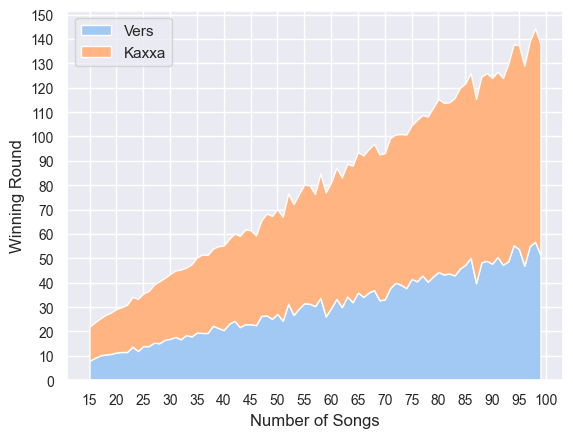

In [255]:
x = [p[0] for p in data]
y  = [[p[1] for p in data],[p[2] for p in data]]



sns.set_theme("notebook",palette="pastel")


# sns.set_theme()


plt.yticks(np.arange(0,300,10),rotation=0,size=10)
plt.xticks(np.arange(0,110,5),rotation=0,size=10)
plt.ylabel("Winning Round")
plt.xlabel("Number of Songs")
plt.stackplot(x,y,labels=["Vers","Kaxxa"])
plt.legend()
plt.show()